# Detect Machine Generated Text - Team IDT

# Importing all libraries 

In [27]:
import numpy as np
import jsonlines
import matplotlib.pyplot as plt
import pandas as pd
import nltk
#nltk.download()
nltk.download('punkt')
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from datetime import datetime
import re
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\av2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import data

In [3]:
machine_data = pd.read_json('small-117M.test.jsonl',lines=True)
human_data = pd.read_json('webtext.test.jsonl',lines=True)

machine_data['machine_generated'] = [1]*machine_data.shape[0]
human_data['machine_generated'] = [0]*human_data.shape[0]

print("Shape of Machine generated dataset :", machine_data.shape)
print("Shape of Human dataset :", human_data.shape)

Shape of Machine generated dataset : (5000, 5)
Shape of Human dataset : (5000, 5)


In [4]:
df = machine_data.append(human_data, ignore_index=True)
df.head()

,ended,id,length,text,machine_generated
0,True,255001,25,The Technology Report empowers or enlightens. ...,1
1,True,255002,323,Available Colors:\n\nWool Revolver\n\nwoodinoo...,1
2,False,255003,1024,OUTLAW CENTER:\n\nUPS & EXPORTS Fulfillment 56...,1
3,False,255004,1024,16 of the past 20 games with each team switche...,1
4,False,255005,1024,The semiconductor industry has become increasi...,1


# Data Cleaning

In [5]:
# This function does cleaning of text in the Dataframe
# We are not removing the stop words because they might be important for us in this example

def clean(data):
    new_data = []
    sentences = nltk.sent_tokenize(data)
    for sentence in sentences:
        sentence = sentence.lower()
        words = nltk.word_tokenize(sentence)
        for word in words:
            new_data.append(word)
    return new_data

In [6]:
for i in range(0,len(df['text'])):
    text = df.loc[i,'text']
    df.at[i,'text'] = " ".join(clean(text))
    
df.head()

,ended,id,length,text,machine_generated
0,True,255001,25,the technology report empowers or enlightens ....,1
1,True,255002,323,available colors : wool revolver woodinooke fa...,1
2,False,255003,1024,outlaw center : ups & exports fulfillment 56 n...,1
3,False,255004,1024,16 of the past 20 games with each team switche...,1
4,False,255005,1024,the semiconductor industry has become increasi...,1


# Evaluation function

In [25]:
def evalModel(y_test,y_pred):
    
    print("Accuracy = ", accuracy_score(y_test, y_pred))
    
    print("Confusion Matrix : ")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    print("Classification Report : ")
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print("Area under ROC curve = ", roc_auc)
    
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

# SVM Model 

In [8]:
# Function for fitting SVM to the training set
def svmModel(X_train,X_test,y_train):
    
    print("Fitting the model started at ", datetime.now())
    classifier = SVC(kernel='linear')
    trained_model = classifier.fit(X_train, y_train)
    print("Predicting started at ", datetime.now())
    y_pred = trained_model.predict(X_test)
    print("Predicted by ", datetime.now())
    return y_pred

# ANN Model

In [9]:
# Function for fitting ANN to the training set
def annModel(X_train,X_test,y_train, epochs):
    
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(46, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    print("Compiling the model started at ", datetime.now())
    # Compile model
    sgd = SGD(lr=0.01, momentum=0.8, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    print("Fitting the model started at ", datetime.now())
    # Fit the model. We manually provide the train and test partition
    history = model.fit(X_train, y_train, validation_split=0.25, epochs=epochs, batch_size=16, verbose=2)
    
    # list all data in history
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    print("Predicting started at ", datetime.now())
    probs = model.predict(X_test)
    print("Predicted by ", datetime.now())
    
    y_pred = []
    for i in probs:
        if(i < 0.5):
            y_pred.append(0)
        else:
            y_pred.append(1)
    
    return y_pred

# SVD 

In [ ]:
# Applying truncatedSVD (as PCA does not support sparse matrix for text) 

text = df['text'].tolist()
vectorizer = TfidfVectorizer(max_features=15000)
X =vectorizer.fit_transform(text).toarray()
y = df['machine_generated'].values

# original data has more than 15000 columns
svd = TruncatedSVD(n_components=3000, random_state=42)
X = svd.fit_transform(X)

# Data Splitting

In [19]:
print("Percentage of variance explained by selected columns: ", svd.explained_variance_ratio_.sum())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

print("The shapes of each of the data sets are: ")
print("\t\t X_train = ", X_train.shape)
print("\t\t y_train = ", y_train.shape)
print("\t\t X_test = ", X_test.shape)
print("\t\t y_test = ", y_test.shape)

Percentage of variance explained by selected columns:  0.7615259183280156
The shapes of each of the data sets are: 
		 X_train =  (8000, 15000)
		 y_train =  (8000,)
		 X_test =  (2000, 15000)
		 y_test =  (2000,)


# Run SVM Model

In [20]:
y_pred_svm = svmModel(X_train,X_test,y_train)

Fitting the model started at  2020-05-20 13:22:56.339925
Predicting started at  2020-05-20 13:43:41.186399
Predicted by  2020-05-20 13:48:44.958916


Accuracy =  0.7755
Confusion Matrix : 
[[827 180]
 [269 724]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      1007
           1       0.80      0.73      0.76       993

   micro avg       0.78      0.78      0.78      2000
   macro avg       0.78      0.78      0.77      2000
weighted avg       0.78      0.78      0.77      2000

Area under ROC curve =  0.775177483696701


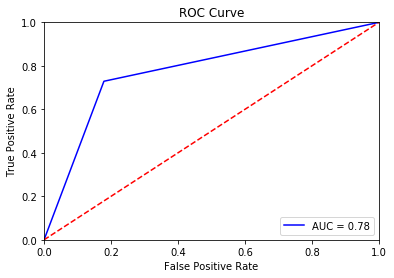

In [28]:
evalModel(y_test,y_pred_svm)

# Run ANN Model

Compiling the model started at  2020-05-20 18:14:01.558228
Fitting the model started at  2020-05-20 18:14:01.642227
Train on 6000 samples, validate on 2000 samples
Epoch 1/3
 - 526s - loss: 0.6816 - acc: 0.5880 - val_loss: 0.6608 - val_acc: 0.6420
Epoch 2/3
 - 522s - loss: 0.5939 - acc: 0.7118 - val_loss: 0.5580 - val_acc: 0.7285
Epoch 3/3
 - 495s - loss: 0.4686 - acc: 0.7812 - val_loss: 0.4898 - val_acc: 0.7530
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


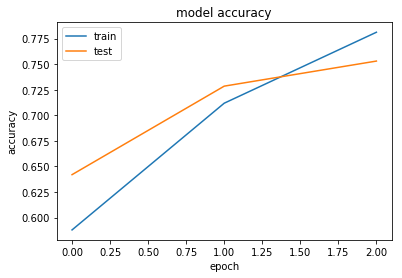

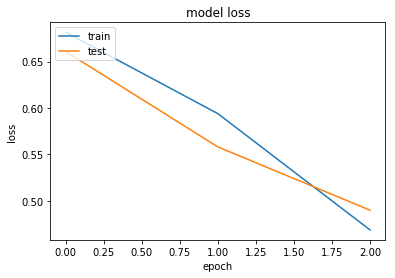

Predicting started at  2020-05-20 18:39:47.016262
Predicted by  2020-05-20 18:40:09.546259


In [30]:
y_pred_ann = annModel(X_train,X_test,y_train,3)

Accuracy =  0.7475
Confusion Matrix : 
[[727 280]
 [225 768]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1007
           1       0.73      0.77      0.75       993

   micro avg       0.75      0.75      0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000

Area under ROC curve =  0.74768013632668


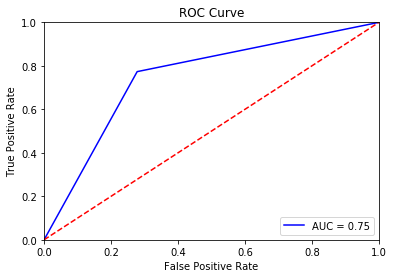

In [31]:
evalModel(y_test,y_pred_ann)

In [32]:
# A better method for solving the problem would be to create our own features from the given text and then
# apply a model on those features.
# Some of the features that can be considered are:
#      - Probability of the word being predicted by a next-word predictor model
#      - Average bigram/trigram probability for each of the sentences 
#      - Average length of a sentence
#      - Ratio of special characters to total no. of characters
#      - No. of special characters used purely for formatting purposes
#      - Counts of each of the POS tagging values ( ~ avg. no. of nouns,verbs,pronouns in a sentence)
#      - Difficulty level in identifying the sentiment of the text
# We can also use some models which can identify grammatical errors in the text data